# Metadata

```
Course:   DS 5001 
Module:   06 HW
Topic:    Similarity and Distance Measures
Author:   R.C. Alvarado
```

# Instructions

In this week’s code exercise, you will compute and explore vector space distances between documents for a corpus of Jane Austen’s novels.

* Use the notebook from class as your guide, as well as any relevant previous notebooks.
* For source data, use the `LIB` and `CORPUS` tables you used last week for the Austem and Melville set. These are in the `/output` directory of 
the course repo. 
* Note that you can use the functions you created last week to compute `TFIDF`; if you had problems with these, you may use functions in the homework key.
* Also, you will need to generate the `VOCAB` table from the Austen corpus; you can import your work from your last homework if you'd like. 

To prepare to answer the questions below, complete the following tasks:

* Add a feature to the `LIB` table for the publication year of the book, using the data provided below. 
  * Create a label for each book using a combination of the year and the book title. 
  * _Scholarly side note_: This is the *publication* year in most cases. For works published posthumously, the year refers to when scholars think the work was actually completed. Note also, there is often a lag between date of completion and data of publication. We will not concern ourselves with these nuances here, but it is always helpful to understand how your data are actually produced.
* Bring into your notebook the functions you created previously to generate a `BOW` table and compute `TFIDF` values. 
Extend the `TFIDF` function so that it also returns the `DFIDF` value for each term in the `VOCAB`.
* Apply these functions to the corpus of Austen's works only, and using *chapters* as bags and `max` as the `TF` count method. 
* Reduce the number of features in the returned `TFIDF` matrix to the **1000 most significant terms**, using `DFIDF` as your significance measure and only using terms whose maximum part-of-speech belongs to this set: `NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS`. Note, these are all **open** categories, excluding proper nounns.
* "Collapse" `TFIDF` matrix that it contains mean `TFIDF` of each term by book. This will result in a matrix with book IDs as rows, and significant terms as columns.
* Use the reduced and collapsed `TFIDF` matrix to compute distance missures between all pairs of books, as we computed in Lab (using `pdist()`). See the table below for the measures to take.
  * As in the template, use the appropriate normed vector space for each metric.
  * You will need to create a table of book pairs (e.g. `PAIRS`).
  * You do *not* need to compute k-means clusters. 
* Create hierarchical agglomerative cluster diagrams for the distance measures, using the appropriate linkage type for each distance measure. Again, see the table below for the appropriate linkage type.
  * Use the labels you created in the `LIB` in your dendograms to help interpret your results.
  
Once you have completed these tasks, answer the questions below.

**Distance Measure and Linkage Method Combos**
```
| Distance Measure | Norming | Linkage  |
|------------------|---------|----------|  
| cityblock        | None    | weighted |
| cosine           | None    | ward     |
| euclidean        | L2      | ward     |  
| jaccard          | L0      | weighted | 
| jensenshannon    | L1      | weighted |
```

**Dates of Austen's Works**
```
| book_id | year | title                                     |
|---------|------|-------------------------------------------|
| 158     | 1815 | Emma                                      |
| 946     | 1794 | Lady Susan                                |
| 1212    | 1790 | Love And Freindship And Other Early Works |
| 141     | 1814 | Mansfield Park                            |
| 121     | 1803 | Northanger Abbey                          |
| 105     | 1818 | Persuasion                                |
| 1342    | 1813 | Pride and Prejudice                       |
| 161     | 1811 | Sense and Sensibility                     |
```

## Q1 

What are the top 10 nouns by `DFIDF`, sorted in descending order? Include plural nouns, but don't include proper nouns. 

Don't worry if your list does not include some terms that have the same 
weights as words in the list. Just take what Pandas gives you with `.head(10)` after sorting with ascending set to `False`.

**Answer**:

```
respect     174	NN	0.022220	177.266344
marriage    246	NN	0.037164	177.261968
fortune     222	NN	0.029135	177.261968
ladies      240	NNS	0.030444	177.258990
question    171	NN	0.018245	177.258990
farther     181	NN	0.018647	177.240001
behaviour   200	NN	0.028989	177.240001
advantage   166	NN	0.022194	177.217644
voice       228	NN	0.024289	177.209470
girl        254	NN	0.033604	177.209470
```


## Q2 

Grouping your `TFIDF` results by book, and taking the mean `TFIDF` of all terms per book, what is Austen's most "significant" book? 

This value is computed from the `TFIDF` matrix your function returned.

**Answer**: Lady Susan

## Q3 

Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works?

That is, which measure show the greatest separation between the first two work and the rest?

Note that the two youthful works were published before 1800.

**Answer**: **Jaccard** shows the most distance between the early and the later works.

## Q4

Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years?  

**Answer**: **No**.

## Q5

Some literary critics believe that _Northanger Abbey_ is, among Austen's mature works, the one that most resembles her _Juvenilia_, i.e. her two works written as a young adult. Which distance measure dendrogram appears to corroborate this thesis?

**Answer**: **Jaccard** shows _Northanger Abbey_ immediately following her earlier works.

# Code

## Set Up

In [1]:
data_home = '../labs-repo/data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [3]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform

## Prepare the Data

Get `LIB`, `CORPUS`, and `VOCAB` for Jane Austen's works.

### Import data from previous work

In [4]:
LIB_raw = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB.csv').set_index('book_id')
CORPUS_raw = pd.read_csv(f'{data_home}/output/{data_prefix}-CORPUS.csv').set_index(OHCO)

### Select Austen's works from `LIB`

In [5]:
LIB = LIB_raw[LIB_raw.author.str.contains("AUS")].copy().sort_index()

In [6]:
LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps
book_id,,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61


### Add publication dates to `LIB`

In [7]:
YYYY = """
book_id year    title
158     1815    Emma
946     1794    Lady Susan
1212    1790    Love And Freindship And Other Early Works
141     1814    Mansfield Park
121     1803    Northanger Abbey
105     1818    Persuasion
1342    1813    Pride and Prejudice
161     1811    Sense and Sensibility
""".split('\n')[1:-1]

In [8]:
YEARS = pd.DataFrame([line.split()[:2] for line in YYYY][1:], columns=['book_id', 'year'])
YEARS.book_id = YEARS.book_id.astype('int')
YEARS = YEARS.set_index('book_id')

In [9]:
LIB['year'] = YEARS

In [10]:
LIB['label'] = LIB.apply(lambda x: f"{x.year}: {x.title}", 1)

In [11]:
LIB['label']

book_id
105                  1818: PERSUASION
121            1803: NORTHANGER ABBEY
141              1814: MANSFIELD PARK
158                        1815: EMMA
161       1811: SENSE AND SENSIBILITY
946                  1794: LADY SUSAN
1212    1790: LOVE AND FREINDSHIP SIC
1342        1813: PRIDE AND PREJUDICE
Name: label, dtype: object

### Select Austen's works from `CORPUS`

In [12]:
CORPUS = CORPUS_raw.loc[LIB.index.values.tolist(), ['pos', 'token_str', 'term_str']].copy()

In [13]:
CORPUS

pos   token_str   term_str
book_id chap_id para_num sent_num token_num                            
105     1       1        0        0          NNP         Sir        sir
                                  1          NNP      Walter     walter
                                  2          NNP     Elliot,     elliot
                                  3           IN          of         of
                                  4          NNP    Kellynch   kellynch
...                                          ...         ...        ...
1342    61      18       0        8           CC         and        and
                                  9          NNP  Prejudice,  prejudice
                                  10          IN          by         by
                                  11         NNP        Jane       jane
                                  12         NNP      Austen     austen

[780873 rows x 3 columns]

### Generate Austen's `VOCAB`

In [14]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['max_pos'] = CORPUS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [15]:
VOCAB

,n,max_pos
term_str,,
the,28274,DT
to,26029,TO
and,24060,CC
of,22927,IN
a,14301,DT
...,...,...
inadvertencies,1,NNS
sobbing,1,VBG
greatcoated,1,VBN


## Vectorize the Data

Generate a `BOW` and computer `TFIDF` and derived quantities.

In [16]:
tf_method = 'max'
bag = CHAP
vocab_filter = 'dfidf'
n_terms = 1000
# pos_list = "CC CD DT EX FW IN MD PDT POS PRP PRP$ RP SYM TO UH WDT WP WP$ WRB LS".split() # Closed categories
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns

### Define functions

Use the function you created previously.

In [17]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [239]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

### Get `BOW` by chapter with `max`

In [240]:
bag

['book_id', 'chap_id']

In [241]:
BOW = create_bow(CORPUS, bag)

In [242]:
tf_method

'max'

In [243]:
TFIDF, DFIDF = get_tfidf(BOW, tf_method)

In [244]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

,term_str,their,how,more,many,himself,sister,on,you,hope,always
book_id,chap_id,,,,,,,,,,
158,1,0.011888,0.020469,0.006246,0.025395,0.014706,0.005074,0.003079,0.043747,0.003824,0.035579
141,8,0.005545,0.002571,0.004461,0.000000,0.003001,0.016569,0.006105,0.019606,0.000000,0.004468
1212,15,0.031540,0.006748,0.004461,0.005183,0.010505,0.000000,0.001257,0.052692,0.010926,0.011729
1342,36,0.006793,0.014696,0.007287,0.009674,0.029413,0.020297,0.008798,0.000000,0.000000,0.007298
141,48,0.029768,0.003185,0.007369,0.000000,0.037179,0.000000,0.008897,0.000000,0.015468,0.007380
161,43,0.017316,0.002470,0.010409,0.011381,0.011534,0.043778,0.008970,0.000673,0.023994,0.002147
946,6,0.000000,0.022674,0.007495,0.017413,0.000000,0.000000,0.006334,0.016469,0.018356,0.026274
121,9,0.006737,0.007808,0.002323,0.007196,0.010939,0.010065,0.007853,0.036580,0.003792,0.008143
1342,2,0.013586,0.037789,0.003123,0.000000,0.000000,0.000000,0.010557,0.078916,0.015296,0.021895


### Reduce `VOCAB` to `n` most significant terms

In [266]:
# DFIDF.sort_values(ascending=False)

In [245]:
VOCAB['dfidf'] = DFIDF

In [245]:
VOCAB['mean_tfidf'] = TFIDF.mean()

In [246]:
n_terms

1000

In [247]:
vocab_filter

'dfidf'

In [248]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values(vocab_filter, ascending=False)\
    .head(n_terms).index

### Reduce `TFIDF` feature space

###  Collapse `TFIDF` by mean bag

In [250]:
M = TFIDF[VIDX].fillna(0).groupby('book_id').mean() # MUST FILLNA

In [274]:
M

term_str,forward,stay,thinking,greatest,respect,fortune,marriage,assure,keep,ladies,...,couple,force,sensations,laugh,inconvenience,niece,description,number,habits,till
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.009262,0.010584,0.011340,0.003233,0.006140,0.013589,0.011468,0.010205,0.005973,0.010620,...,0.003639,0.000543,0.007360,0.000873,0.004510,0.000000,0.013781,0.008072,0.006116,0.007750
121,0.006748,0.008810,0.008241,0.007326,0.004111,0.010054,0.005660,0.008954,0.005668,0.012311,...,0.002833,0.004548,0.002145,0.007287,0.001490,0.000000,0.008629,0.008718,0.002851,0.010037
141,0.009500,0.009412,0.010821,0.010356,0.009049,0.006946,0.007412,0.004308,0.009863,0.006468,...,0.005363,0.003853,0.007835,0.004720,0.006282,0.018120,0.002553,0.004042,0.009751,0.009845
158,0.008882,0.011392,0.014596,0.007157,0.011402,0.010334,0.009475,0.014604,0.008835,0.011061,...,0.009435,0.003532,0.006615,0.008453,0.004739,0.009043,0.003256,0.004511,0.006200,0.009874
161,0.006474,0.008128,0.005347,0.009488,0.006497,0.012934,0.013288,0.009847,0.009249,0.009851,...,0.006831,0.006641,0.001596,0.009584,0.009412,0.002029,0.002513,0.005238,0.001201,0.010393
946,0.010188,0.005638,0.001255,0.015570,0.010156,0.005375,0.021950,0.005513,0.014674,0.000000,...,0.000000,0.002964,0.005358,0.001439,0.000000,0.010203,0.008612,0.000000,0.000000,0.009533
1212,0.001501,0.000884,0.003517,0.010051,0.003126,0.011411,0.016403,0.011138,0.004595,0.005799,...,0.007730,0.003442,0.002735,0.000000,0.000339,0.000000,0.011037,0.002193,0.000000,0.007163
1342,0.006757,0.012313,0.007312,0.005553,0.009518,0.014328,0.020465,0.013715,0.009678,0.026033,...,0.004362,0.004699,0.001252,0.013745,0.003562,0.010457,0.004319,0.002116,0.001980,0.011637


In [276]:
# M2 = TFIDF.fillna(0).groupby('book_id').mean()[VIDX] # MUST FILLNA

In [277]:
# M2

### Normalize `TFIDF` for distance measuring

In [252]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

### Generate doc pairs

In [253]:
PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [254]:
general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

In [255]:
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

In [256]:
PAIRS.style.background_gradient('GnBu', high=.5)

In [257]:
PAIRS.corr().style.background_gradient(cmap='GnBu', high=.5)

,correl,euclidean,cosine,cityblock,jaccard,js
correl,1.000000,0.093538,0.100085,0.105621,0.147002,0.126429
euclidean,0.093538,1.000000,0.998540,0.985599,0.962054,0.996756
cosine,0.100085,0.998540,1.000000,0.980221,0.963509,0.996019
cityblock,0.105621,0.985599,0.980221,1.000000,0.943970,0.985831
jaccard,0.147002,0.962054,0.963509,0.943970,1.000000,0.973634
js,0.126429,0.996756,0.996019,0.985831,0.973634,1.000000


## Visualize

### Define function

In [258]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [259]:
def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.label.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{label}–{linkage_method}", fontsize=20)
    
#     return fig

### Generate for each combo

<Figure size 432x288 with 0 Axes>

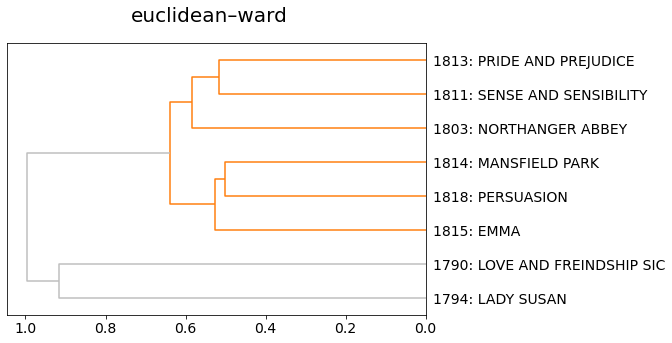

<Figure size 432x288 with 0 Axes>

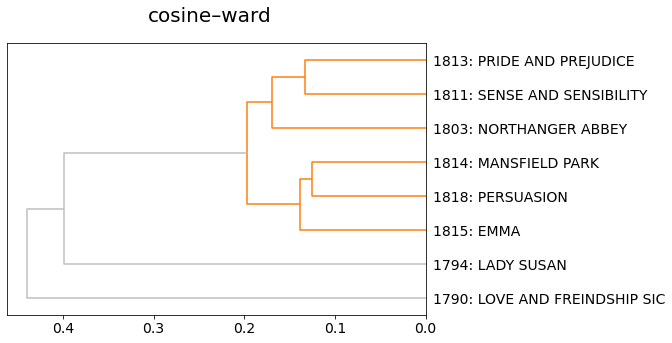

<Figure size 432x288 with 0 Axes>

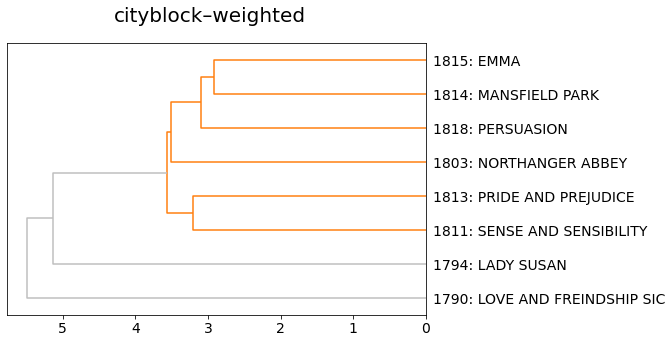

<Figure size 432x288 with 0 Axes>

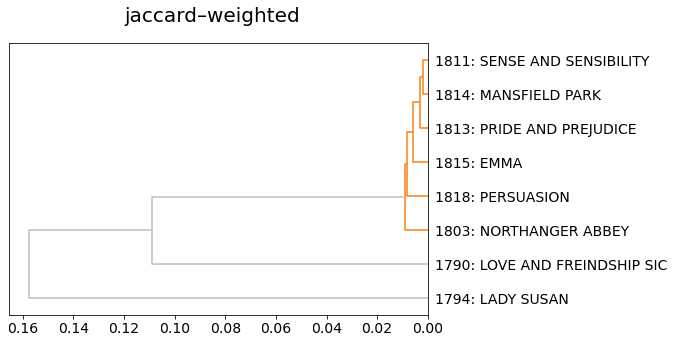

<Figure size 432x288 with 0 Axes>

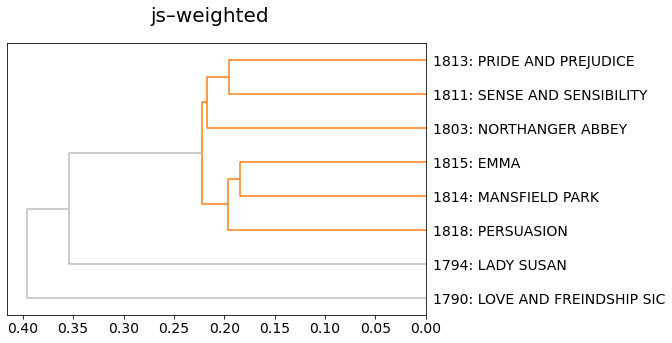

In [260]:
for X, metric, label, linkage in combos:
    draw_hca(PAIRS[label], linkage_method=linkage)

## Save

In [40]:
BOW_REDUCED = M.stack().to_frame('tfidf_mean')
BOW_REDUCED['binary']   = L0.stack()
BOW_REDUCED['tfidf_l1'] = L1.stack()
BOW_REDUCED['tfidf_l2'] = L2.stack()
BOW_REDUCED = BOW_REDUCED.sort_index()

In [41]:
BOW_REDUCED

tfidf_mean  binary  tfidf_l1  tfidf_l2
book_id term_str                                          
105     able          0.010594       1  0.000539  0.016079
        absence       0.014404       1  0.000733  0.021860
        absolutely    0.015428       1  0.000786  0.023414
        accept        0.021947       1  0.001118  0.033309
        accepted      0.021105       1  0.001075  0.032031
...                        ...     ...       ...       ...
1342    yes           0.021459       1  0.000653  0.019547
        yesterday     0.031415       1  0.000956  0.028616
        younger       0.055566       1  0.001692  0.050614
        yours         0.033757       1  0.001028  0.030749
        youth         0.039542       1  0.001204  0.036018

[8000 rows x 4 columns]

# Answers

## Q1

Top 10 Nouns using DFIDF?

In [82]:
VOCAB['dfidf'] = DFIDF

In [84]:
VOCAB.sort_values('dfidf', ascending=False).query('max_pos == "NN" or max_pos == "NNS"').head(10)

,n,max_pos,dfidf,mean_tfidf
term_str,,,,
respect,174,NN,177.266344,0.022220
fortune,222,NN,177.261968,0.029135
marriage,246,NN,177.261968,0.037164
ladies,240,NNS,177.258990,0.030444
question,171,NN,177.258990,0.018245
behaviour,200,NN,177.240001,0.028989
farther,181,NN,177.240001,0.018647
advantage,166,NN,177.217644,0.022194
girl,254,NN,177.209470,0.033604


## Q2 

Most significant book?

**<span style="color:red;">NOTE:</span>** The anwser to this question depends on two factors:
* Whether the `TFIDF` table has nulls or not. It should have nulls replaced by 0s, using `fillna(0)`
but early I had told the students to keep nulls in the table in order to more easily compute `DF` from the `TFIDF` table. 
* Whether they use the full or the reduced `TFIDF` table. The intent of the question was to use the full table, but I can see that this is not completely clear.

We will accept all combinations.

Collapse TFIDF by book

In [269]:
# TFIDF.groupby('book_id').mean()

In [270]:
# TFIDF.stack().groupby('book_id').mean()

In [197]:
LIB['mean_tfidf'] = TFIDF.stack().groupby('book_id').mean()

In [198]:
LIB.loc[LIB.mean_tfidf.idxmax()].title

'LADY SUSAN'

In [199]:
TFIDF2 = TFIDF.fillna(0)

In [200]:
LIB['mean_tfidf2'] = TFIDF2.stack().groupby('book_id').mean()

In [201]:
LIB.loc[LIB.mean_tfidf2.idxmax()].title

'NORTHANGER ABBEY'

# Class

In [48]:
class TfidfVectorizer():
    
    item_type:str = 'term_str'
    tf_method:str = 'max'
    df_method:str = 'standard'
    V:pd.DataFrame = None
    
    
    def __init__(self, CORPUS:pd.DataFrame, VOCAB:pd.DataFrame):
        self.CORPUS = CORPUS
        self.VOCAB = VOCAB
        self.OHCO = list(CORPUS.index.names)
    
    def create_bow(self, ohco_level):
        self.bag = self.OHCO[:ohco_level]
        self.BOW = self.CORPUS.groupby(self.bag+[self.item_type])\
            [self.item_type].count().to_frame('n')
        
    def get_tfidf(self):
        
        DTCM = self.BOW.n.unstack() # Create Doc-Term Count Matrix w/NULLs
        self.V = pd.DataFrame(index=DTCM.columns)

        if 'max_pos' in VOCAB:
            self.V['max_pos'] = self.VOCAB.max_pos
        
        if self.tf_method == 'sum':
            TF = (DTCM.T / DTCM.T.sum()).T
        elif self.tf_method == 'max':
            TF = (DTCM.T / DTCM.T.max()).T
        elif self.tf_method == 'log':
            TF = (np.log2(1 + DTCM.T)).T
        elif self.tf_method == 'raw':
            TF = DTCM
        elif self.tf_method == 'bool':
            TF = DTCM.astype('bool').astype('int')
        else:
            raise ValueError(f"TF method {tf_method} not found.")

        DF = DTCM.count()
        N_docs = len(DTCM)

        if self.df_method == 'standard':
            IDF = np.log2(N_docs/DF) # This what the students were asked to use
        elif self.df_method == 'textbook':
            IDF = np.log2(N_docs/(DF + 1))
        elif self.df_method == 'sklearn':
            IDF = np.log2(N_docs/DF) + 1
        elif self.df_method == 'sklearn_smooth':
            IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
        else:
            raise ValueError(f"DF method {df_method} not found.")
    
        TFIDF = TF * IDF
        
        self.BOW['tfidf'] = TFIDF.stack()
        self.BOW['tf'] = TF.stack()
        self.V['df'] = DF
        self.V['idf'] = IDF
        self.N_docs = N_docs
        
    def get_dfidf(self):
        self.V['dfidf'] = self.V.df * self.V.idf
        
    def get_mean_tfidf_for_VOCAB(self):
        self.V['mean_tfidf'] = self.BOW.groupby('term_str').tfidf.mean()


In [49]:
# tv = TfidfVectorizer(CORPUS, VOCAB)
# tv.create_bow(2)
# tv.get_tfidf()
# tv.get_dfidf()

# Experiment

## Effect of filling nulls at various points

Means vary becuase $N$ varies in the denominator.

In [206]:
M0 = TFIDF.groupby('book_id').mean()           # FILLNA not done
M1 = TFIDF.fillna(0).groupby('book_id').mean() # FILLNA before grouping -- CORRECT
M2 = TFIDF.groupby('book_id').mean().fillna(0) # FILLNA after grouping (same as M0)

In [207]:
M0

term_str,0,1,10,10000,10th,11th,12,12th,1399,13th,...,youthful,youths,yrs,z,zeal,zealous,zealously,zephyr,zigzags,ł20000
book_id,,,,,,,,,,,,,,,,,,,,,
105,NaN,0.119092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.043417,NaN,NaN,0.067611,0.034021,0.051703,0.060030,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.043488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,NaN,NaN,0.083509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.038694,0.036242,NaN,NaN,NaN,0.047099
158,NaN,NaN,NaN,0.232881,NaN,NaN,NaN,NaN,NaN,NaN,...,0.049044,NaN,NaN,NaN,0.040002,NaN,NaN,NaN,0.066537,NaN
161,NaN,0.076121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.078830,NaN,NaN,NaN,0.040051,0.056965,0.139315,NaN,NaN,NaN
946,NaN,NaN,0.183750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.316688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1212,0.047232,NaN,NaN,NaN,0.118983,0.023616,0.167674,0.023616,0.032621,0.035164,...,NaN,NaN,0.128944,NaN,NaN,0.045126,NaN,0.023616,NaN,NaN
1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.092129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
M1

term_str,0,1,10,10000,10th,11th,12,12th,1399,13th,...,youthful,youths,yrs,z,zeal,zealous,zealously,zephyr,zigzags,ł20000
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000000,0.004962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.001809,0.00000,0.000000,0.002817,0.005670,0.004309,0.002501,0.000000,0.00000,0.000000
121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.002806,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
141,0.000000,0.000000,0.003480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.004031,0.000755,0.000000,0.000000,0.00000,0.000981
158,0.000000,0.000000,0.000000,0.004234,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.001783,0.00000,0.000000,0.000000,0.002909,0.000000,0.000000,0.000000,0.00121,0.000000
161,0.000000,0.001522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.003153,0.00000,0.000000,0.000000,0.001602,0.002279,0.002786,0.000000,0.00000,0.000000
946,0.000000,0.000000,0.004482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.007724,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1212,0.001968,0.000000,0.000000,0.000000,0.009915,0.000984,0.006986,0.000984,0.001359,0.00293,...,0.000000,0.00000,0.021491,0.000000,0.000000,0.001880,0.000000,0.000984,0.00000,0.000000
1342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [171]:
M2

term_str,0,1,10,10000,10th,11th,12,12th,1399,13th,...,youthful,youths,yrs,z,zeal,zealous,zealously,zephyr,zigzags,ł20000
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000000,0.119092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.043417,0.000000,0.000000,0.067611,0.034021,0.051703,0.060030,0.000000,0.000000,0.000000
121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.043488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
141,0.000000,0.000000,0.083509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.038694,0.036242,0.000000,0.000000,0.000000,0.047099
158,0.000000,0.000000,0.000000,0.232881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.049044,0.000000,0.000000,0.000000,0.040002,0.000000,0.000000,0.000000,0.066537,0.000000
161,0.000000,0.076121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.078830,0.000000,0.000000,0.000000,0.040051,0.056965,0.139315,0.000000,0.000000,0.000000
946,0.000000,0.000000,0.183750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.316688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1212,0.047232,0.000000,0.000000,0.000000,0.118983,0.023616,0.167674,0.023616,0.032621,0.035164,...,0.000000,0.000000,0.128944,0.000000,0.000000,0.045126,0.000000,0.023616,0.000000,0.000000
1342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.092129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
